**Importing the Dependencies**

In [1]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# loading the dataset to a pandas dataframe
df = pd.read_csv("spotify_millsongdata.csv")

In [3]:
df.shape

(57650, 4)

In [5]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2066 to 3895
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  10000 non-null  object
 1   song    10000 non-null  object
 2   text    10000 non-null  object
dtypes: object(3)
memory usage: 312.5+ KB


In [13]:
df.isnull().sum()

artist    0
song      0
text      0
dtype: int64

In [14]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Rolling Stones    45
George Strait     41
Ray Charles       41
Jimmy Buffett     38
John Denver       38
Diana Ross        38
Elton John        37
Glen Campbell     36
Donna Summer      36
Rod Stewart       36
Name: count, dtype: int64


In [15]:
df = df.sample(10000)

df = df.drop('link', axis=1).reset_index(drop=True)

KeyError: "['link'] not found in axis"

In [10]:
df.shape

(10000, 3)

In [11]:
df.head()

,artist,song,text
0,Wiz Khalifa,Fly solo,[Chorus] \nI had a dream that the whole world...
1,Tears For Fears,The Way You Are,"Going far, \nGetting nowhere \nGoing far, \..."
2,Kelly Family,Babylon,"I'm the anger, yeah, that you got in your bone..."
3,Dusty Springfield,Earthbound Gypsy,Trees that grow without ground \nYoung leaves...
4,Dave Matthews Band,"Drive In, Drive Out",I hear more than I like to... \nSo I boil my ...


In [12]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

WordCloud to visualize the most common words in the lyrics.

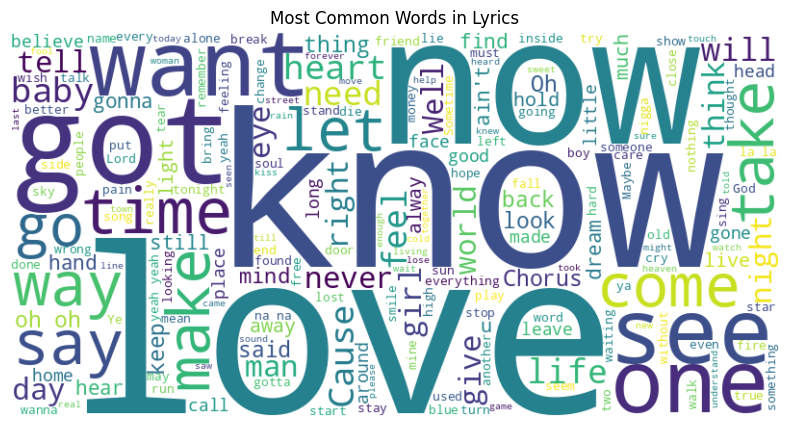

In [13]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

**Data Preprocessing**

In [14]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/prophet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/prophet/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/prophet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stop_words = set(stopwords.words('english'))

In [16]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [19]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [20]:
df.head()

,artist,song,text,cleaned_text
0,Journey,Tantra,"One light shining bright, it's made from many ...",one light shining bright made many colors like...
1,Yazoo,Walk Away From Love,Move along you're in my way. \nI've made my m...,move along youre way ive made mind stay dont m...
2,Patti Smith,White Rabbit,One pill makes you larger \nOne pill makes yo...,one pill makes larger one pill makes small one...
3,Chuck Berry,I Will Not Let You Go,"I will not let you go, I will not let you go, ...",let go let go let go know love want need cant ...
4,Cher,It's The Little Things,You're not the kind of guy \nThat make the gi...,youre kind guy make girls sigh never turn head...


In [20]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])
tfidf_matrix


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 565354 stored elements and shape (10000, 5000)>

In [2]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


NameError: name 'cosine_similarity' is not defined

In [23]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [24]:
df["song"][6]

'Come A Little Bit Closer'

In [25]:
# Example Recommendation
print("\nRecommendations for the song 'Blinded By Rainbows':")
recommendations = recommend_songs("For The First Time") # df["song"][2]
print(recommendations)


Recommendations for the song 'Blinded By Rainbows':
             artist                         song
2732  Kenny Loggins           For The First Time
9400  Conway Twitty           First Things First
5703   Human League       Get It Right This Time
8752   Howard Jones  Let Me Be The First To Know
4291      Van Halen              Hot For Teacher
